In [17]:
from sklearn import preprocessing

SETSofVALS = 25
def generateHeader():
    header = []
    for i in range(1,SETSofVALS+1):
        header.append("x"+str(i))
        header.append("y"+str(i))
        header.append("z"+str(i))
        header.append("block"+str(i))
    header.append("biome")
    return header

def encode_columns_dummy(df, header):
    for i in range(1, SETSofVALS+1):
        encode_text_dummy(df,header+str(i))
        
#code below taken from https://github.com/jeffheaton/t81_558_deep_learning
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)
    
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

    
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   


In [34]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


path = "./Data/"

filename_read = os.path.join(path,"data_cleaned3.csv")

#below two are for not cleaned data
#header = generateHeader() 
#df = pd.read_csv(filename_read, names=header)

df = pd.read_csv(filename_read)

#shuffling - not required as the splitting into train/test does the shuffling for us
#df = df.reindex(np.random.permutation(df.index))
#df.reset_index(inplace=True, drop=True)

biomes = encode_text_index(df,"biome")
encode_columns_dummy(df, "block")
x,y = to_xy(df,"biome")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(50, activation='relu')) # Hidden 2
model.add(Dense(25, activation='relu')) # Hidden 3
model.add(Dense(y.shape[1],activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam')

#early stopping 
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=25, verbose=1, mode='auto')
#getting best weights 
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=1000)
model.load_weights('best_weights.hdf5') # load weights from best model

#df

/Users/saadghani/Development/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch 00079: early stopping


In [33]:
len(x_train[0])

1118

In [27]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [37]:
pred = model.predict(x_test)
print("Shape: {}".format(pred.shape))
print(pred)

predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y_test,axis=1)
print(f"Predictions: {predict_classes}")
print(f"Expected: {expected_classes}")

from sklearn.metrics import accuracy_score
# Accuracy might be a more easily understood error metric.  It is essentially a test score.  For all of the iris predictions,
# what percent were correct?  The downside is it does not consider how confident the neural network was in each prediction.
correct = accuracy_score(expected_classes,predict_classes)
print(f"Accuracy: {correct}")

Shape: (1200, 6)
[[1.16e-06 9.81e-01 8.07e-09 1.64e-11 1.03e-06 1.93e-02]
 [4.96e-01 1.57e-02 1.45e-01 2.45e-01 5.30e-02 4.52e-02]
 [4.79e-01 7.54e-03 1.52e-01 2.88e-01 4.49e-02 2.74e-02]
 ...
 [5.99e-01 1.91e-03 1.89e-01 1.56e-01 4.69e-02 7.35e-03]
 [3.87e-02 3.17e-01 1.38e-01 1.32e-02 1.35e-01 3.58e-01]
 [1.22e-05 9.84e-01 1.49e-06 1.51e-08 4.67e-05 1.55e-02]]
Predictions: [1 0 0 ... 0 5 1]
Expected: [1 3 0 ... 2 5 1]
Accuracy: 0.6058333333333333


Confusion matrix, without normalization
[[162   4  13  30   4   2]
 [  7 139   6   4  11  55]
 [ 24   3  86  24  28  11]
 [ 27   4  14 158   0   1]
 [ 12   8  59   8  81  21]
 [  8  52  15   4  14 101]]
Normalized confusion matrix
[[0.75 0.02 0.06 0.14 0.02 0.01]
 [0.03 0.63 0.03 0.02 0.05 0.25]
 [0.14 0.02 0.49 0.14 0.16 0.06]
 [0.13 0.02 0.07 0.77 0.   0.  ]
 [0.06 0.04 0.31 0.04 0.43 0.11]
 [0.04 0.27 0.08 0.02 0.07 0.52]]


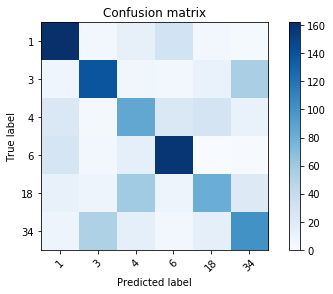

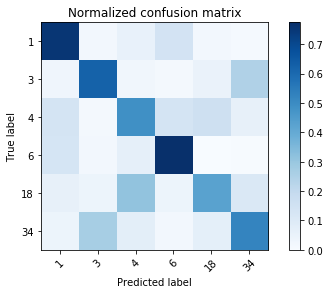

In [38]:
#evaluating data graphically

import numpy as np

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test2 = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_test2, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, biomes)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, biomes, title='Normalized confusion matrix')

plt.show()